Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
acceleration_input (InputLayer) [(None, 125, 1)]     0                                            
__________________________________________________________________________________________________
heart_rate_input (InputLayer)   [(None, 126, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_72 (Conv1D)              (None, 125, 256)     512         acceleration_input[0][0]         
__________________________________________________________________________________________________
conv1d_75 (Conv1D)              (None, 121, 256)     1792        heart_rate_input[0][0]           
___________________________________________________________________________________________

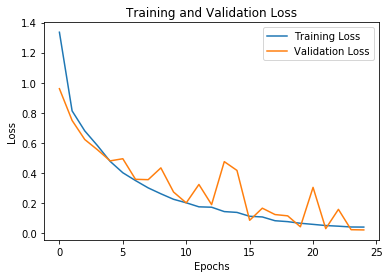

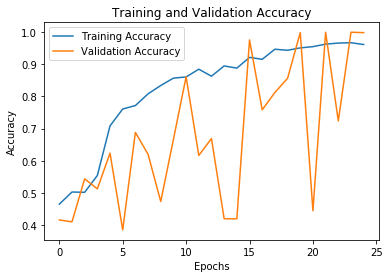

27/27 [==============================] - 1s 20ms/step - loss: 0.0236 - accuracy: 0.9976
Test Loss: 0.02355179749429226
Test Accuracy: 0.9976190328598022
Confusion Matrix:
[[279   0   0]
 [  1 267   0]
 [  0   1 292]]


In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from sklearn.utils import class_weight
import warnings
from keras.layers import Input, Convolution1D, MaxPool1D, Flatten, Dense, BatchNormalization
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Convolution1D, BatchNormalization, MaxPool1D, Flatten, Dense, concatenate
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.layers import Input, Convolution1D, MaxPool1D, Flatten, Dense, concatenate, Attention
from keras.models import Model
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from keras.regularizers import l1
from keras.losses import mean_squared_error,mean_absolute_error,CategoricalCrossentropy
from keras.optimizers import Adam,Nadam, RMSprop,Adamax,Adagrad
from keras.losses import mean_squared_logarithmic_error
from keras.losses import mean_squared_error

df = pd.DataFrame()
mypath = 'NEW_BASE_DATASET_WITH_DISTANCE1.csv'
df = pd.read_csv(mypath)


from sklearn.utils import resample
df_1=df[df["label"]==1]
df_2=df[df["label"]==2]
df_0=(df[df["label"]==0]).sample(n=1400,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=1400,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=1400,random_state=123)
df=pd.concat([df_0,df_1_upsample,df_2_upsample])

# Drop unnecessary columns
df = df.drop(['Id','eventID','hr','max_acceleration','std_deviation','overall_distance'], axis=1)

# Split the dataframe into acceleration and heart rate data
acceleration_data = df.iloc[:, :125].values
heart_rate_data = df.iloc[:, 125:].values

# Split the data into train and test sets
X_acceleration_train, X_acceleration_test, X_heart_rate_train, X_heart_rate_test, y_train, y_test = train_test_split(
    acceleration_data, heart_rate_data, df["label"], test_size=0.2, random_state=333)

# Convert labels to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Reshape the data for convolutional layers
X_acceleration_train = X_acceleration_train.reshape(len(X_acceleration_train), X_acceleration_train.shape[1], 1)
X_acceleration_test = X_acceleration_test.reshape(len(X_acceleration_test), X_acceleration_test.shape[1], 1)
X_heart_rate_train = X_heart_rate_train.reshape(len(X_heart_rate_train), X_heart_rate_train.shape[1], 1)
X_heart_rate_test = X_heart_rate_test.reshape(len(X_heart_rate_test), X_heart_rate_test.shape[1], 1)

# Define the model
def create_model():
    # Acceleration branch
    acceleration_input = Input(shape=(X_acceleration_train.shape[1], 1), name='acceleration_input')
    conv1_acc = Convolution1D(256, (1), activation='relu')(acceleration_input)
    pool1_acc = MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv1_acc)
    conv2_acc = Convolution1D(128, (1), activation='relu')(pool1_acc)
    pool2_acc = MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_acc)
    conv3_acc = Convolution1D(64, (1), activation='relu')(pool2_acc)
    pool3_acc = MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_acc)
    attention_acc = Attention()([pool3_acc, pool3_acc])  # Add attention mechanism
    flatten_acc = Flatten()(attention_acc)

    # Heart rate branch
    heart_rate_input = Input(shape=(X_heart_rate_train.shape[1], 1), name='heart_rate_input')
    conv1_hr = Convolution1D(256, (6), activation='relu')(heart_rate_input)
    pool1_hr = MaxPool1D(pool_size=(2), strides=(1), padding="same")(conv1_hr)
    conv2_hr = Convolution1D(128, (1), activation='relu')(pool1_hr)
    pool2_hr = MaxPool1D(pool_size=(2), strides=(1), padding="same")(conv2_hr)
    conv3_hr = Convolution1D(64, (1), activation='relu')(pool2_hr)
    pool3_hr = MaxPool1D(pool_size=(2), strides=(1), padding="same")(conv3_hr)
    attention_hr = Attention()([pool3_hr, pool3_hr])  # Add attention mechanism
    flatten_hr = Flatten()(attention_hr)

    # Merge both branches
    merged = concatenate([flatten_acc, flatten_hr])
    from tensorflow.keras.layers import LeakyReLU

    from tensorflow.keras.regularizers import l2

    # Dense layers with L2 regularization
    dense1 = Dense(64, kernel_regularizer=l2(0.01))(merged)
    dense1 = BatchNormalization()(dense1)
    dense1 = LeakyReLU(alpha=0.1)(dense1)
    dense1 = Dropout(0.3)(dense1)

    dense2 = Dense(64, kernel_regularizer=l2(0.01))(dense1)
    dense2 = BatchNormalization()(dense2)
    dense2 = LeakyReLU(alpha=0.1)(dense2)
    dense2 = Dropout(0.3)(dense2)
    
    output = Dense(3, activation='softmax', name='output')(dense2)

    # Define model
    model = Model(inputs=[acceleration_input, heart_rate_input], outputs=output)

    # Compile model
    optimizer = RMSprop(learning_rate=0.0001)  # Set custom learning rate

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])

    return model

# Create model
model = create_model()

# Print model summary
model.summary()

from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt


# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=0.00001, verbose=1)

# Callbacks
callbacks = [
    ModelCheckpoint(
        "../Models/model.h5", save_best_only=True, monitor="val_loss"
    ),
    reduce_lr,  # Include ReduceLROnPlateau callback
]


history = model.fit([X_acceleration_train, X_heart_rate_train], y_train, epochs=25, batch_size=16, validation_data=([X_acceleration_test, X_heart_rate_test], y_test), callbacks=callbacks)

# Plot training loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Evaluate the model
loss, accuracy = model.evaluate([X_acceleration_test, X_heart_rate_test], y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Predict the labels
y_pred = model.predict([X_acceleration_test, X_heart_rate_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)


In [16]:
model.save('Models/overfitter_model.h5')

In [17]:
from keras.models import load_model
model = load_model('Models/overfitter_model.h5')